In [1]:
import json
import web3
import ipdb
import os

#from web3 import Web3
from web3 import Web3, HTTPProvider
from solc import compile_source
from web3.contract import ConciseContract

import pandas as pd
import time
import random

import numpy as np
import time

data = pd.read_csv("Llaves.csv") 

public_keys = data['Llave Publica']
private_keys = data['Llave Privada']

w3 = Web3(HTTPProvider("https://rinkeby.infura.io/v3/4c0ec7f1412a489d91e1934c66ebf5b1"))
hostname = "google.com" #example

## Smart Contracts

In [2]:
## Coops

Coops_abi = open("./abi/Coops.json", "r")
c_values = json.load(Coops_abi)
Coops_abi.close()
coops = w3.eth.contract(
    address = '0x2c66b176962911D2ce40f5809cD52C73c8E78356',
    abi = c_values,
)

## Propietarios

Propietarios_abi = open("./abi/Propietarios.json", "r")
o_values = json.load(Propietarios_abi)
Propietarios_abi.close()
propietarios = w3.eth.contract(
    address = '0xD5fbF619121824aCB4e7aAf66A1d86947CE87f1B',
    abi = o_values,
)

## Proveedores

Proveedores_abi = open("./abi/Proveedores.json", "r")
v_values = json.load(Proveedores_abi)
Proveedores_abi.close()
proveedores = w3.eth.contract(
    address = '0x71eCEF369c041955C9993c635144a629c82CcD86',
    abi = v_values,
)

## Instaladores

Instaladores_abi = open("./abi/Instaladores.json", "r")
i_values = json.load(Instaladores_abi)
Instaladores_abi.close()
instaladores = w3.eth.contract(
    address = '0xC0ed1D311963EFc99418C0C84Ff2661CF199f9b0',
    abi = i_values
)

## Gestores

Gestores_abi = open("./abi/Gestores.json", "r")
m_values = json.load(Gestores_abi)
Gestores_abi.close()
gestores = w3.eth.contract(
    address = '0x23215E9FFaE52Eaf79c861d4F620A9748f3652C1',
    abi = m_values
)

## CF

CF_abi = open("./abi/CF.json", "r")
cf_values = json.load(CF_abi)
CF_abi.close()
cf = w3.eth.contract(
    address = '0x4Bac31B5056b1975D286d552F64F7962b8f2b2cc',
    abi = cf_values
)

## Proyectos

Proyectos_abi = open("./abi/Proyectos.json", "r")
p_values = json.load(Proyectos_abi)
Proyectos_abi.close()
proyectos = w3.eth.contract(
    address = '0x05c24902c594c255E4d2FA9B5D8ca7c1d44A7E85',
    abi = p_values
)

## Matching (off-chain)

In [3]:
def match(public_keys,private_keys): 
    i_interest_rate = proyectos.call().interest_rate()
    i_demands = propietarios.call().getUserCount()
    for i_demand in range(i_demands):
        address_d = propietarios.call().getUserAtIndex(i_demand)
        b_funding = propietarios.call().getFunding(address_d)
        i_MaxPrice = propietarios.call().getDemand(address_d)
        i_vendors = proveedores.call().getProvidersCount()
        for i_vendor in range(i_vendors):
            address_v = proveedores.call().getProviderAtIndex(i_vendor)
            i_price_v = proveedores.call().getProvider(address_v)
            i_installers = instaladores.call().getInstallersCount()
            for i_installer in range(i_installers):
                address_i = instaladores.call().getInstallerAtIndex(i_installer)
                i_price_i = instaladores.call().getInstaller(address_i)
                i_managers = gestores.call().getManagersCount()
                for i_manager in range(i_managers): 
                    address_m = gestores.call().getManagerAtIndex(i_manager)
                    i_price_m = gestores.call().getManager(address_m)

                    i_projectcost = int((i_price_v + i_price_i + i_price_m)*(100+i_interest_rate)/100)
                    if i_projectcost <= i_MaxPrice:
                        if b_funding == False:
                            print('Project Cost = '+str(i_projectcost))
                            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
                            construct_txn = proyectos.functions.Matching(address_d,address_v,
                                                                         address_i,address_m).buildTransaction({
                                'from': acct.address,
                                'nonce': w3.eth.getTransactionCount(acct.address),
                                'gasPrice': w3.toWei('1.4', 'gwei')})

                            signed = acct.signTransaction(construct_txn)

                            tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

                            # Wait for the transaction to be mined, and get the transaction receipt
                            tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                            return (tx_receipt,b_funding)


                        elif b_funding == True:
                            print(i_projectcost)
                            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
                            construct_txn = cf.functions.Crowdsale(address_d,address_v,address_i,
                                                                   address_m,1).buildTransaction({
                                'from': acct.address,
                                'nonce': w3.eth.getTransactionCount(acct.address),
                                'gas': 3000000,
                                'gasPrice': w3.toWei('1.4', 'gwei')})

                            signed = acct.signTransaction(construct_txn)
                            tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                            tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                            
                            return (tx_receipt,b_funding)
                        
    print('No match found')
    return False
                    


## Limpiar deudas

In [24]:
for i in range(1,len(public_keys)):
    totaldebt = coops.call().getTotalDebt(public_keys[i])
    print('Debt of '+public_keys[i]+' = '+str(totaldebt)+ '  Coops')
    if totaldebt > 0:
        acct = w3.eth.account.privateKeyToAccount(private_keys[i])
        for address in public_keys:
            debt = coops.call().getDebt(acct.address,address)
            if debt > 0: 
                construct_txn = coops.functions.Pay(address,debt).buildTransaction({
                    'from': acct.address,
                    'nonce': w3.eth.getTransactionCount(acct.address),
                    'gas': 3000000,
                    'gasPrice': w3.toWei('1.4', 'gwei')})
                signed = acct.signTransaction(construct_txn)

                tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                # Wait for the transaction to be mined, and get the transaction receipt
                tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                print('Debt of '+acct.address+' = '+str(coops.call().getTotalDebt(acct.address))+ '  Coops')

Debt of 0x6C740120A054cecF209BCaCF62fC38Cc64D98499 = 0  Coops
Debt of 0x520597cF4C6f9aed321a39a12529911350c7d0BF = 0  Coops
Debt of 0x6c2a6C2F7B3ABf37575a423E72d91C78F72B36E8 = 0  Coops
Debt of 0x29b93fdD9D9BE8c80d483aA94CA12496f09006C8 = 0  Coops
Debt of 0xF7ab85D5391651B239873fE0Cf26B6B2f0E52358 = 0  Coops
Debt of 0xe19e53113C2901eDec0Ff21a30Bcc28CFEB7c04B = 0  Coops
Debt of 0x2E3CaF2E65021aaA035c8ede24CCb361aC16659A = 0  Coops
Debt of 0x3f274122c33CED256d0F5D46f420ad6b92d4D9E5 = 0  Coops
Debt of 0xc30B42346A4d15AAdfA44cBf885E758dbe110b86 = 0  Coops
Debt of 0xa543D290F7B5FFCc94999935CF8E50f70a29C9bb = 0  Coops
Debt of 0x46D2b966Cf2195145aA3A9028aCDf0A1763E065F = 0  Coops
Debt of 0xAb7F3ccbBEb7d93605bDE9E0589F773FD4F21EC4 = 0  Coops
Debt of 0xbe9dAaA8007a325d21BA5104bCba75085e22b5E0 = 0  Coops
Debt of 0x13079510D41706bc7880d7C20Df1a5AaE3A26A25 = 0  Coops
Debt of 0xE793eF9f5D743F0Bb959144A34de76cD0b8eF6B4 = 0  Coops
Debt of 0xbd10542D544CC2bA88DBEaD8e387508DE1B1Fcc3 = 0  Coops
Debt of 

## Devolver Coops

In [ ]:
for i in range(1,len(public_keys)):
    address = public_keys[i]
    response = os.system("ping -c 1 " + hostname)
    while response != 0:
        print('No Internet Connection')
        response = os.system("ping -c 1 " + hostname) 
    balance = coops.call().balanceOf(address)
    if balance > 0:
        acct = w3.eth.account.privateKeyToAccount(private_keys[i])
        construct_txn = coops.functions.transfer(public_keys[0],balance).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1.4', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        
    print('Balance of '+address+' = '+str(coops.call().balanceOf(address))+ '  Coops')


## Repartir Coops

In [ ]:
i_addresses = 120
acct = w3.eth.account.privateKeyToAccount(private_keys[0])
response = os.system("ping -c 1 " + hostname)
while response != 0:
    #print('No Internet Connection')
    response = os.system("ping -c 1 " + hostname) 
    
balance = int(coops.call().balanceOf(public_keys[0])/(i_addresses)/2.4)
for i in range(1,i_addresses+1):
    address = public_keys[i]
    i_balance = int(coops.call().balanceOf(public_keys[i]))
    if i_balance == 0: 
        construct_txn = coops.functions.transfer(address,balance).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1.4', 'gwei')})
        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Balance of '+address+' = '+str(coops.call().balanceOf(address))+ '  Coops')

## CUD (Propietarios)

In [4]:
reference_price = 2190000
min_price = int(reference_price*0.4)
i_addresses = 120
totTransactions = 0
gas_newdemand = []
gas_editdemand = []
gas_deletedemand = []

for i in range(1,i_addresses+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    b_funding = bool(random.getrandbits(1))
    i_MaxPrice = random.randint(min_price,reference_price)
    if propietarios.call().isDemand(public_keys[i]) == False:
        construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by New Demand = '+str(tx_receipt.gasUsed))
        gas_newdemand.append(tx_receipt.gasUsed)
        totTransactions += 1


for i in range(1,i_addresses+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    if propietarios.call().isDemand(public_keys[i]) == True:
        i_MaxPrice = random.randint(min_price,reference_price)
        b_funding = bool(random.getrandbits(1))
        construct_txn = propietarios.functions.updatemaxPrice(i_MaxPrice).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})
        signed = acct.signTransaction(construct_txn)
        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by Update Demand = '+str(tx_receipt.gasUsed))
        gas_editdemand.append(tx_receipt.gasUsed)
        totTransactions += 1
        
        construct_txn = propietarios.functions.deleteDemand(acct.address).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})
        signed = acct.signTransaction(construct_txn)
        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by Delete Demand = '+str(tx_receipt.gasUsed))
        gas_deletedemand.append(tx_receipt.gasUsed)
        totTransactions += 1

print('Total Txs = '+str(totTransactions))

gas_editdemand.reverse()
gas_deletedemand.reverse()


Gas used by New Demand = 60636
Gas used by New Demand = 76487
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 96415
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76615
Gas used by New Demand = 66351
Gas used by New Demand = 96415
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 76615
Gas used by New Demand = 96415
Gas used by New Demand = 66351
Gas used by New Demand = 76615
Gas used by New Demand = 66351
Gas used by New Demand = 96415
Gas used by New Demand = 76551
Gas used by New Demand = 96415
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 96415
Gas used by New Demand = 76615
Gas used by New Demand = 76615
Gas used by New Demand = 76551
Gas used by New Demand = 96415
Gas used by New Demand = 76615
Gas used by New Demand = 76551
Gas used by New Demand = 96415
Gas used

Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23041
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by De

## Matching s/Financiamiento

In [7]:
i_props = 30
i_provs = 30
i_insts = 30
i_gests = 30
i_projects = 30

b_funding = False
i_MaxPrice = 2000000
i_price_v = 1000000
i_price_i = 100000
i_price_m = 10000

gas_match = []

#===================Demand==========================
for i in range(1,i_props+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    if propietarios.call().isDemand(public_keys[i]) == False:
        construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by New Demand = '+str(tx_receipt.gasUsed))

#===================VENDOR==========================
for i in range(i_props+1,i_props+i_provs+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    construct_txn = proveedores.functions.newProvider(i_price_v).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Vendor = '+str(tx_receipt.gasUsed))

#===================INSTALLER==========================
for i in range(i_props+i_provs+1,i_props+i_provs+i_insts+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    construct_txn = instaladores.functions.newInstaller(i_price_i).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Installer = '+str(tx_receipt.gasUsed))

#===================MANAGER==========================
for i in range(i_props+i_provs+i_insts+1,i_addresses+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])

    construct_txn = gestores.functions.newManager(i_price_m).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Manager = '+str(tx_receipt.gasUsed))

print('Propietarios = '+str(propietarios.call().getUserCount()))
print('Proveedores = '+str(proveedores.call().getProvidersCount()))
print('Instaladores = '+str(instaladores.call().getInstallersCount()))
print('Gestores = '+str(gestores.call().getManagersCount()))

#===================MATCHING==========================

xmatch = match(public_keys,private_keys) 
while xmatch != False:
    tx_receipt = xmatch[0]
    gas_match.append(tx_receipt.gasUsed)
    print('Gas used by Matching = '+str(tx_receipt.gasUsed))
    xmatch = match(public_keys,private_keys)

gas_match.reverse()

Gas used by New Demand = 70836
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Vendor = 69881
Gas used by New Vendor = 75590
Gas used

## Matching c/Financiamiento

In [29]:
i_props = 24
i_provs = 24
i_insts = 24
i_gests = 24
i_finan = 24
i_projects = 24

i_MaxPrice = 0
totalCost = 1

gas_matchf = []
gas_check = []
gas_withdraw = []

while totalCost > i_MaxPrice:
    reference_price = 2190000
    min_price = int(reference_price*0.4)
    b_funding = True
    i_MaxPrice = random.randint(min_price,reference_price)

    reference_price = 2190000
    min_price = int(reference_price*0.1)
    i_price_v = random.randint(min_price,reference_price)

    reference_price = int(2190000*0.5)
    min_price = int(reference_price*0.2)
    i_price_i = random.randint(min_price,reference_price)

    reference_price = int(2190000*0.5)
    min_price = int(reference_price*0.1)
    i_price_m = random.randint(min_price,reference_price)

    i_txs = 0
    gas_used = 0

    prevCost = i_price_v + i_price_i + i_price_m
    fee = int(prevCost * proyectos.call().interest_rate() / 100)
    totalCost = prevCost + fee

print('Total Cost = '+str(totalCost))


#===================Demand==========================
for i in range(1,i_props+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    if propietarios.call().isDemand(public_keys[i]) == False:
        construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by New Demand = '+str(tx_receipt.gasUsed))

#===================VENDOR==========================
for i in range(i_props+1,i_props+i_provs+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    if proveedores.call().isProvider(public_keys[i]) == False:
        construct_txn = proveedores.functions.newProvider(i_price_v).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by New Vendor = '+str(tx_receipt.gasUsed))

#===================INSTALLER==========================
for i in range(i_props+i_provs+1,i_props+i_provs+i_insts+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    if instaladores.call().isInstaller(public_keys[i]) == False:
        construct_txn = instaladores.functions.newInstaller(i_price_i).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by New Installer = '+str(tx_receipt.gasUsed))

#===================MANAGER==========================
for i in range(i_props+i_provs+i_insts+1,i_props+i_provs+i_insts+i_finan+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    if gestores.call().isManager(public_keys[i]) == False:
        construct_txn = gestores.functions.newManager(i_price_m).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by New Manager = '+str(tx_receipt.gasUsed))

print('Propietarios = '+str(propietarios.call().getUserCount()))
print('Proveedores = '+str(proveedores.call().getProvidersCount()))
print('Instaladores = '+str(instaladores.call().getInstallersCount()))
print('Gestores = '+str(gestores.call().getManagersCount()))

#===================MATCHING, CHECK(S) & WITHDRAWAL ==========================

xmatch = match(public_keys,private_keys) 
while xmatch != False:
    tx_receipt = xmatch[0]
    gas_matchf.append(tx_receipt.gasUsed)
    print('Gas used by Matching = '+str(tx_receipt.gasUsed))
    acct = w3.eth.account.privateKeyToAccount(private_keys[0])
    while cf.call().crowdsaleClosed() == False:
        construct_txn = cf.functions.checkGoalReached().buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)
        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        gas_check.append(tx_receipt.gasUsed)
        print('Gas used by Check = '+str(tx_receipt.gasUsed))



    for i in range(1,i_props+1):
        if public_keys[i] == cf.call().beneficiary():
            print('beneficiary: '+ public_keys[i])
            acct = w3.eth.account.privateKeyToAccount(private_keys[i])
            construct_txn = cf.functions.safeWithdrawal().buildTransaction({
                'from': acct.address,
                'nonce': w3.eth.getTransactionCount(acct.address),
                'gas': 3000000,
                'gasPrice': w3.toWei('1', 'gwei')})

            signed = acct.signTransaction(construct_txn)

            tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)            
            # Wait for the transaction to be mined, and get the transaction receipt
            tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
            gas_withdraw.append(tx_receipt.gasUsed)
            
            print('Gas used by Whitdrawal = '+str(tx_receipt.gasUsed))

            print('Propietarios = '+str(propietarios.call().getUserCount()))
            print('Proveedores = '+str(proveedores.call().getProvidersCount()))
            print('Instaladores = '+str(instaladores.call().getInstallersCount()))
            print('Gestores = '+str(gestores.call().getManagersCount()))
    
    xmatch = match(public_keys,private_keys)

gas_matchf.reverse()
gas_check.reverse()
gas_withdraw.reverse()

Total Cost = 1548903
Gas used by New Demand = 76615
Gas used by New Vendor = 75590
Gas used by New Vendor = 75590
Gas used by New Installer = 75480
Gas used by New Installer = 75480
Gas used by New Installer = 75480
Gas used by New Manager = 75502
Gas used by New Manager = 75502
Gas used by New Manager = 75502
Propietarios = 24
Proveedores = 24
Instaladores = 24
Gestores = 24
1382133
Gas used by Matching = 71368
Gas used by Check = 21624
Gas used by Check = 21624
Gas used by Check = 21624
Gas used by Check = 32093
beneficiary: 0xEE36bc02B667D1054d36371e14b13238f03d0B4B
Gas used by Whitdrawal = 634172
Propietarios = 23
Proveedores = 23
Instaladores = 23
Gestores = 23
1548903
Gas used by Matching = 71368
Gas used by Check = 21624
Gas used by Check = 21624
Gas used by Check = 21624
Gas used by Check = 32093
beneficiary: 0x979f9c5847d8f843186fBc7e2580828c4e1f875D
Gas used by Whitdrawal = 594572
Propietarios = 22
Proveedores = 22
Instaladores = 22
Gestores = 22
1548903
Gas used by Matching 

## Pagos

In [122]:
i_MaxPrice = 0
totalCost = 1
i_limit = 64
gas_pay = []
gas_xwith = []
gas_matchp = []

while totalCost > i_MaxPrice:
    reference_price = 2190000
    min_price = int(reference_price*0.4)
    b_funding = True
    i_MaxPrice = random.randint(min_price,reference_price)

    reference_price = 2190000
    min_price = int(reference_price*0.1)
    i_price_v = random.randint(min_price,reference_price)

    reference_price = int(2190000*0.5)
    min_price = int(reference_price*0.2)
    i_price_i = random.randint(min_price,reference_price)

    reference_price = int(2190000*0.5)
    min_price = int(reference_price*0.1)
    i_price_m = random.randint(min_price,reference_price)

    i_txs = 0
    gas_used = 0

    prevCost = i_price_v + i_price_i + i_price_m
    fee = int(prevCost * proyectos.call().interest_rate() / 100)
    totalCost = prevCost + fee

print('Total Cost = '+str(totalCost))

for i in range(5,len(public_keys)):
    
    print(i_limit)
    
    response = os.system("ping -c 1 " + hostname)
    while response != 0:
        print('No Internet Connection')
        response = os.system("ping -c 1 " + hostname)
        
    #===================Demand==========================
    acct = w3.eth.account.privateKeyToAccount(private_keys[1])

    construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)
    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Demand = '+str(tx_receipt.gasUsed))


    #===================VENDOR==========================
    acct = w3.eth.account.privateKeyToAccount(private_keys[2])

    construct_txn = proveedores.functions.newProvider(i_price_v).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)
    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Vendor = '+str(tx_receipt.gasUsed))

    #===================INSTALLER==========================
    acct = w3.eth.account.privateKeyToAccount(private_keys[3])

    construct_txn = instaladores.functions.newInstaller(i_price_i).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)
    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Installer = '+str(tx_receipt.gasUsed))

    #===================MANAGER==========================
    acct = w3.eth.account.privateKeyToAccount(private_keys[4])

    construct_txn = gestores.functions.newManager(i_price_m).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)
    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Manager = '+str(tx_receipt.gasUsed))

    #===================MATCHING==========================
    xmatch = match(public_keys,private_keys)
    if xmatch != False: 
        if xmatch[1] == True:
            tx_receipt = xmatch[0]
            print('Gas used by Matching = '+str(tx_receipt.gasUsed))
    gas_matchp.append(tx_receipt.gasUsed)
    #===================FUNDING==========================
    fundingGoal = cf.call().fundingGoal()
    i_part = int(fundingGoal/(i_limit-4))
    i_sum = 0
    
    for j in range(5,i_limit):
        response = os.system("ping -c 1 " + hostname)
        while response != 0:
            print('No Internet Connection')
            response = os.system("ping -c 1 " + hostname)        
        acct = w3.eth.account.privateKeyToAccount(private_keys[j])
        construct_txn = coops.functions.Fund(cf.address,i_part).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)
        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        i_sum += i_part
        print('Gas used by Fund = '+str(tx_receipt.gasUsed))
    
    delta = fundingGoal - cf.call().amountRaised()
    
    acct = w3.eth.account.privateKeyToAccount(private_keys[i_limit])
    construct_txn = coops.functions.Fund(cf.address,delta).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)
    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by Fund = '+str(tx_receipt.gasUsed))
           

    #===================CHECK(S) & WITHDRAWAL==========================
    acct = w3.eth.account.privateKeyToAccount(private_keys[1])

    print('Balance of '+acct.address+' = '+str(coops.call().balanceOf(acct.address))+ '  Coops')
    while cf.call().crowdsaleClosed() == False:
        construct_txn = cf.functions.checkGoalReached().buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)
        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by Check = '+str(tx_receipt.gasUsed))

    construct_txn = cf.functions.safeWithdrawal().buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)
    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by Whitdrawal = '+str(tx_receipt.gasUsed))
    gas_xwith.append(tx_receipt.gasUsed)
    time.sleep(5)
    print('Generate')

    j = proyectos.call().numProjects()-1
    holder = proyectos.call().getProject(j)[0]
    acct = w3.eth.account.privateKeyToAccount(private_keys[public_keys == holder].values[0])
    generated = np.sum(np.random.normal(5, 0.4, 30))
    construct_txn = coops.functions.Generate(int(generated),j).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gasPrice': w3.toWei('1.4', 'gwei')})
    signed = acct.signTransaction(construct_txn)
    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by Generate = '+str(tx_receipt.gasUsed))
    gas_pay.append(tx_receipt.gasUsed)
    i_limit -= 1
    
print(public_keys[1]+' totaldebt = ' + str(coops.call().getTotalDebt(public_keys[1])))

acct = w3.eth.account.privateKeyToAccount(private_keys[1])
for address in public_keys:
    response = os.system("ping -c 1 " + hostname)
    while response != 0:
        print('No Internet Connection')
        response = os.system("ping -c 1 " + hostname)        
    debt = coops.call().getDebt(acct.address,address)
    if debt > 0: 
        construct_txn = coops.functions.Pay(address,debt).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1.4', 'gwei')})
        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Debt of'+acct.address+' = '+str(coops.call().getTotalDebt(acct.address))+ '  Coops')

gas_pay.reverse()
gas_xwith.reverse()
gas_matchp.reverse()

Total Cost = 1911768
64
Gas used by New Demand = 70900
Gas used by New Vendor = 69881
Gas used by New Installer = 69771
Gas used by New Manager = 69793
1911768
Gas used by Matching = 362059
Gas used by Fund = 191296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas 

Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Gas used by Fund = 116296
Balance of 0x6C740120A054cecF209BCaCF62fC38Cc64D98499 = 70361736  Coops
Gas used by Check 

KeyboardInterrupt: 

In [3]:
gas_newdemand_save = [60636,76487,66351,76551,96415,76551,76551,76615,66351,96415,76551,66351,76615,96415,66351,76615,
66351,96415,76551,96415,66351,66351,76551,76551,96415,76615,76615,76551,96415,76615,76551,96415,66351,76615,96415,
76615,66351,66351,96415,96415,66351,66351,76615,66351,96415,96415,76615,76551,66351,76615,76551,96415,76615,96415,
76551,96415,96415,66351,96415,66351,66351,76615,96415,76615,76615,76551,66351,76551,76615,76551,96415,76615,76615,
76615,76551,76615,76551,76551,66351,96415,96415,96415,96415,96415,76615,76551,76551,76551,96415,76615,96415,66351,
76551,76551,76551,76551,96415,76551,76487,66351,96415,76615,96415,76551,66351,96415,66351,76551,76551,76551,96415,
76615,96415,76615,96415,66351,76615,66351,76551,76551]

gas_editdemand_save = [30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,
                       30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,
                       30558,30558,30558,30558,30558,30558,30558,30558,30494,30558,30558,30558,30558,30558,30558,
                       30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,
                       30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,
                       30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,
                       30558,30558,30558,30558,30558,30558,30558,30558,30558,30494,30558,30558,30558,30558,30558,
                       30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558]

gas_deletedemand_save = [20673,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23041,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23041,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23041,
 23073,
 23073,
 23073,
 23073,
 23073,
 23041,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23073,
 23009,
 23073,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27841,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27841,
 27841,
 27873,
 27873,
 27873,
 27841,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27841,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 27873,
 25473]

gas_match_save = [525119,
 563711,
 563711,
 563711,
 563711,
 563647,
 563711,
 563711,
 563711,
 563711,
 563711,
 563647,
 563711,
 563711,
 563711,
 563711,
 563647,
 563711,
 563711,
 563711,
 563711,
 563647,
 563583,
 563711,
 563711,
 563647,
 563711,
 563711,
 563711,
 563647]

gas_matchf_save = [71368,
 68936,
 68968,
 68968,
 68904,
 68936,
 68936,
 68968,
 68968,
 68968,
 68936,
 68936,
 68904,
 68968,
 68968,
 68968,
 68968,
 71368,
 71368,
 71368,
 71368,
 68968,
 71368,
 71368]

gas_check_save = [32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 32093,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624]

gas_withdraw_save = [674972,
 688772,
 698372,
 698372,
 698372,
 698372,
 698372,
 718172,
 718172,
 718172,
 718172,
 718172,
 718172,
 678572,
 718172,
 718172,
 718172,
 718172,
 638972,
 470972,
 678572,
 594572,
 594572,
 634172]

In [144]:
gas_withdraw

[674972,
 688772,
 698372,
 698372,
 698372,
 698372,
 698372,
 718172,
 718172,
 718172,
 718172,
 718172,
 718172,
 678572,
 718172,
 718172,
 718172,
 718172,
 638972,
 470972,
 678572,
 594572,
 594572,
 634172]

In [4]:
gas_xwith_save = [5156967,5040925,4999883,4958842,4917800,4876759,4835717,4794676,4753634,4712592,4671551,
                  4630510,4589468,4548426,4507386,4466344,4425302,4384262,4343220,4302180,4261138,4220097,
                  2783678,2742638,2701598,2660558,2619518,2578478,2537438,2496398,2455358,
                  731716, 690678,649639,608601,567563,526524,485486,444448,403410,362372]
gas_pay_save = [2738351,989982,981613,973244,964875,956506,948137,939768,931399,923030,914661,906292,897923,889554,
                881185,872816,864447,856078,847709,839340,830971,822602,
                529687, 521318, 512949, 504580, 496211, 487842, 479473, 471104, 462799,
                111237,102868,94499,86130, 77761, 69392,61023,52654,44285,35916]
linsp = [116,115,114,113,112,111,110,109,108,107,106,105,104,103,102,101,100,99,98,97,96,95,
         60,59,58,57,56,55,54,53,52,
         10,9,8,7,6,5,4,3,2,1]
gas_matchp_save = [114658,637354,632305,627256,622207,617158,612109,607060,602011,150001,591913,586864,581815,
                   576766,571717,566668,561619,556570,551521,546472,541423,
                   362059, 359659, 354610, 349561, 344512, 339463, 334414, 329365, 324316,
                   286324,107209,102160,97111,92062,87013,81964,76915,71866,66817]
xlinsp = [115,114,113,112,111,110,109,108,107,106,105,104,103,102,101,100,99,98,97,96,95,
          60,59,58,57,56,55,54,53,52,
          10,9,8,7,6,5,4,3,2,1]

In [127]:
gas_matchp

[362059, 359659, 354610, 349561, 344512, 339463, 334414, 329365, 324316]

## Plot

Text(0.5, 0, 'Oferta + Demanda')

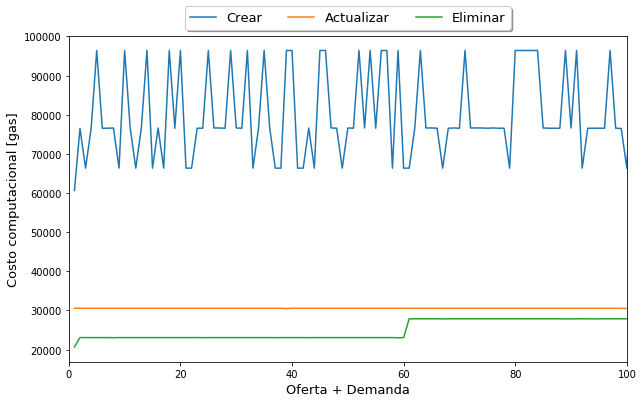

In [48]:
n = np.linspace(1,120,120)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(n,gas_newdemand_save,label='Crear')
plt.plot(n,gas_editdemand_save,label='Actualizar')
plt.plot(n,gas_deletedemand_save,label='Eliminar')

#plt.plot(n4,gas_match)
plt.margins(x=0)
plt.xlim(0,100)
#plt.margins(x=100)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11),
          fancybox=True, shadow=True, ncol=5, fontsize=13)
plt.ylabel('Costo computacional [gas]', fontsize=13)
plt.xlabel('Oferta + Demanda', fontsize=13)

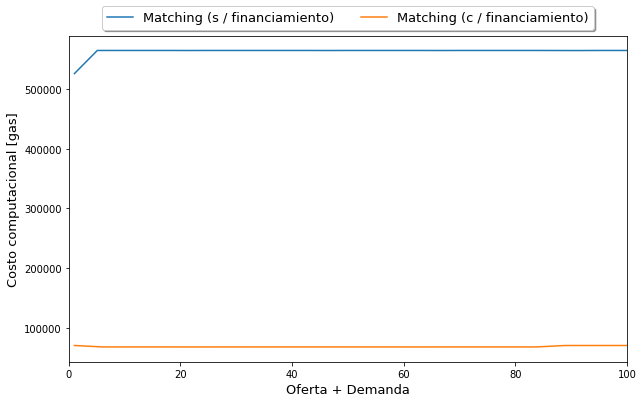

In [49]:
n = np.linspace(1,120,120)
n4 = np.linspace(1,120,30)
n5 = np.linspace(1,120,24)
nc = np.linspace(1,120,len(gas_check_save))

plt.figure(figsize=(10,6))

plt.plot(n4,gas_match_save,label='Matching (s / financiamiento)')
plt.plot(n5,gas_matchf_save,label='Matching (c / financiamiento)')
plt.margins(x=0)
plt.xlim(0,100)
plt.ylabel('Costo computacional [gas]', fontsize=13)
plt.xlabel('Oferta + Demanda', fontsize=13)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11),
          fancybox=True, shadow=True, ncol=5, fontsize=13)

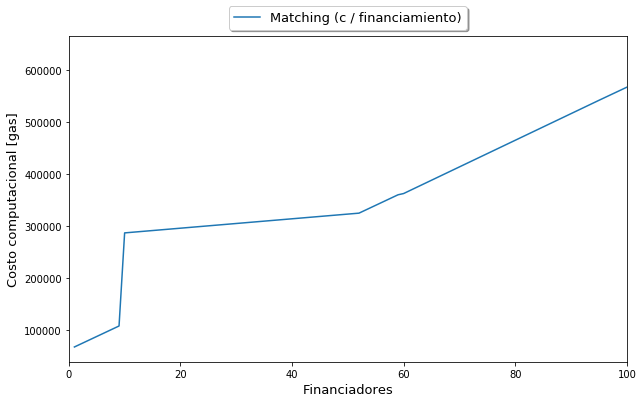

In [52]:
plt.figure(figsize=(10,6))

plt.plot(xlinsp,gas_matchp_save,label='Matching (c / financiamiento)')
#plt.plot(nc,gas_check_save,label='Check')
plt.margins(x=0)
plt.xlim(0,100)
plt.ylabel('Costo computacional [gas]', fontsize=13)
plt.xlabel('Financiadores', fontsize=13)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11),
          fancybox=True, shadow=True, ncol=5, fontsize=13)

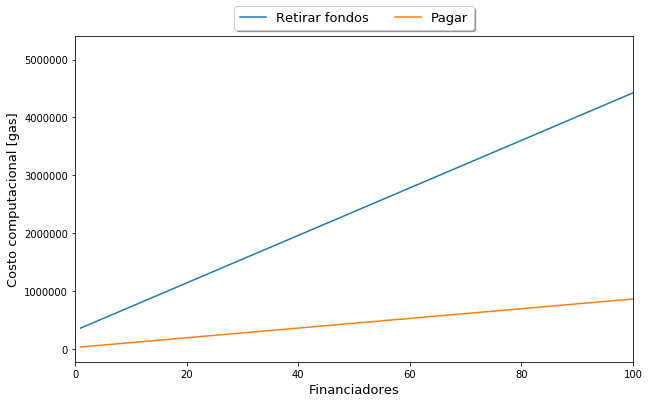

In [55]:
n = np.linspace(1,120,120)
n4 = np.linspace(1,120,30)
n5 = np.linspace(1,120,24)
nc = np.linspace(1,120,len(gas_check_save))
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(linsp,gas_xwith_save,label='Retirar fondos')
plt.plot(linsp,gas_pay_save,label='Pagar')
plt.margins(x=0)
plt.xlim(0,100)
plt.ylabel('Costo computacional [gas]', fontsize=13)
plt.xlabel('Financiadores', fontsize=13)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11),
          fancybox=True, shadow=True, ncol=5, fontsize=13)

In [19]:
gas_check_save

[32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 32093,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624,
 32093,
 21624,
 21624,
 21624]

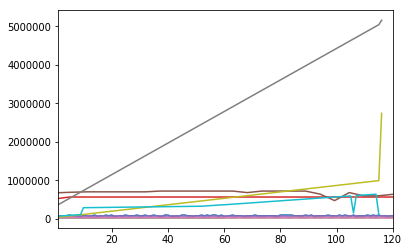

In [143]:
n4 = np.linspace(1,120,30)
n5 = np.linspace(1,120,24)
nc = np.linspace(1,120,len(gas_check))
import matplotlib.pyplot as plt
plt.plot(n,gas_newdemand,label='Crear')
plt.plot(n,gas_editdemand,label='Actualizar')
plt.plot(n,gas_deletedemand,label='Eliminar')
plt.plot(n4,gas_match)
plt.plot(n5,gas_matchf)
plt.plot(nc,gas_check)
plt.plot(n5,gas_withdraw)
plt.plot(linsp,gas_xwith_save)
plt.plot(linsp,gas_pay_save)
plt.plot(xlinsp,gas_matchp_save)
plt.margins(x=0)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t[0:12],balances[6,0:12],label='Propietario')
plt.plot(t[0:12],balances[15,0:12],label='Proveedor')
plt.plot(t[0:12],balances[20,0:12],label='Instalador')
plt.plot(t[0:12],balances[30,0:12],label='Gestor')
plt.plot(t[0:12],balances[33,0:12],label='Financiador')
plt.xlabel('Mes', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
#plt.legend()
plt.margins(x=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=5, fontsize=13)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t[0:12],balances[7,0:12],label='Propietario')
plt.plot(t[0:12],balances[10,0:12],label='Proveedor')
plt.plot(t[0:12],balances[23,0:12],label='Instalador')
plt.plot(t[0:12],balances[31,0:12],label='Gestor')
#plt.plot(t[0:12],balances[33,0:12],label='Financiador')
plt.xlabel('Mes', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
#plt.legend()
plt.margins(x=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=5, fontsize=13)